# Train A Shape Classifier Model



In [ ]:
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [1]:
import json
import os

train_data_root = "../datasets/train"
test_data_root = "../datasets/test"

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations (including resizing and normalization)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (black and white images)
    transforms.Resize((64, 64)),  # Resize images to 64x64 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the images (mean=0.5, std=0.5 for grayscale)
])

# Load the dataset
train_dataset = datasets.ImageFolder(root=train_data_root, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_root, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names (optional)
print(f'Classes: {train_dataset.classes}')

# 2. Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # 3 classes: circle, triangle, rectangle
        
    def forward(self, x):
        x = F.relu(self.conv1(x))   # First Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = F.relu(self.conv2(x))   # Second Conv Layer
        x = F.max_pool2d(x, 2)      # Max Pooling
        x = x.view(x.size(0), -1)   # Flatten
        x = F.relu(self.fc1(x))     # Fully Connected Layer 1
        x = self.fc2(x)             # Fully Connected Layer 2 (output)
        return x

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')




Classes: ['circle', 'diamond', 'triangle']


# Train

In [7]:
train_model(model, train_loader, criterion, optimizer, epochs=15)

Epoch [1/15], Loss: 1.1223, Accuracy: 37.57%
Epoch [2/15], Loss: 1.0012, Accuracy: 49.43%
Epoch [3/15], Loss: 0.9227, Accuracy: 56.00%
Epoch [4/15], Loss: 0.8141, Accuracy: 63.00%
Epoch [5/15], Loss: 0.6396, Accuracy: 74.14%
Epoch [6/15], Loss: 0.4663, Accuracy: 82.71%
Epoch [7/15], Loss: 0.3057, Accuracy: 90.14%
Epoch [8/15], Loss: 0.2139, Accuracy: 93.00%
Epoch [9/15], Loss: 0.1717, Accuracy: 94.00%
Epoch [10/15], Loss: 0.1223, Accuracy: 96.00%
Epoch [11/15], Loss: 0.0922, Accuracy: 97.00%
Epoch [12/15], Loss: 0.0579, Accuracy: 98.57%
Epoch [13/15], Loss: 0.0364, Accuracy: 99.57%
Epoch [14/15], Loss: 0.0267, Accuracy: 99.71%
Epoch [15/15], Loss: 0.0150, Accuracy: 99.86%


# Test 

In [16]:
def test(model, test_loader):
    """Print the Precision, Recall and F1-score for the trained model
    """
    model.eval()

    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_name = test_loader.dataset.classes
    num_classes = len(class_name)

    true_pos = [0] * num_classes
    false_pos = [0] * num_classes
    false_neg = [0] * num_classes

    for pred, label in zip(all_preds,all_labels):
        if pred == label:
            true_pos[label] += 1
        else:
            false_pos[pred] +=1
            false_neg[label] +=1

    print(f"{'Class':<10}{'Pre':<10}{'Recall':<10}{'F1':<10}")
    print()

    for i in range(num_classes):
        precision = true_pos[i]/(true_pos[i]+false_pos[i])
        recall = true_pos[i]/(true_pos[i]+false_neg[i])
        f1 = 2 * (precision*recall) / (precision + recall)
        
        print(f"{class_name[i]:<10}{precision:.3f}     {recall:.3f}     {f1:.3f}")
    pass
test(model,test_loader)

Class     Pre       Recall    F1        

circle    0.650     0.663     0.657
diamond   0.604     0.624     0.614
triangle  0.941     0.896     0.918


# Show Predictions


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

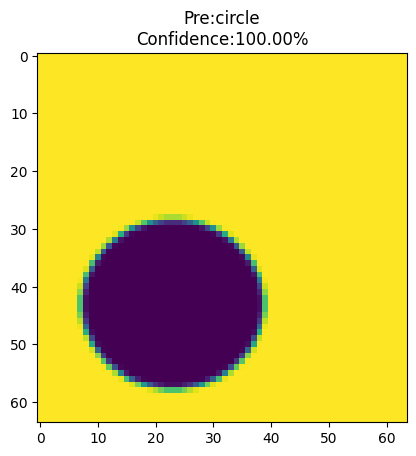

In [35]:
def show_prediction(model, image):
    """Pass the image to the model and overlay the predicted shape and confidence on the input
    image and display it
    """
    model.eval()

    transformed_image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        probabilities = F.softmax(output,dim=1)
        confidence, predicted = torch.max(probabilities,1)

    class_names = train_dataset.classes
    pre_class = class_names[predicted.item()]
    confidence = confidence.item()

    img = transformed_image.squeeze().cpu().numpy()
    img = img *0.5+0.5
    img = np.expand_dims(img,axis=-1)
    img = img.squeeze() if img.shape[2] == 1 else img

    plt.figure()
    plt.imshow(img)
    plt.title(f'Pre:{pre_class}\nConfidence:{confidence:.2%}')
    plt.show()

    pass

files = os.listdir("../datasets/test/circle")
img_files = [f for f in files if f.endswith(".png")]

show_prediction(model, Image.open(os.path.join("../datasets/test/circle",img_files[0])))